## Shopping Mall 지점별 매출액 예측

1. Import & Data check  
2. EDA  
3. Feature Engineering
4. Modeling & submission

## 1. Import & Data Check

1) 데이터 확인  
2) 이상치 탐색 및 제거  
3) 결측치 확인  
4) 비대칭도 확인  

In [2]:
# ! pip install missingno

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import datetime

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
os.listdir('./dataset/shoppingmall')

['sample_submission.csv', 'test.csv', 'train.csv']

In [6]:
df_train = pd.read_csv('./dataset/shoppingmall/train.csv')
df_test = pd.read_csv('./dataset/shoppingmall/test.csv')

### 1) 데이터 확인

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [14]:
df_train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [10]:
df_train.shape, df_test.shape
# 6255개의 데이터

((6255, 13), (180, 12))

In [13]:
df_test.columns
# target 변수 Weekly_Sales 라는 점 다시 확인

Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday'],
      dtype='object')

### 2) 이상치 탐색 및 제거 - 수치형 변수 사용

In [17]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5*IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v> n)
    
    return multiple_outliers

Outlier_to_drop = detect_outliers(df_train, 2, ['id', 'Store','Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment'])

In [18]:
df_train.loc[Outlier_to_drop]
# 없

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales


### 3) 결측치 확인

In [20]:
df_train.isnull().sum()
# 프로모션 1~ 5에 결측치 존재
# 이 프로모션은 도대체 뭘까

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [21]:
df_test.isnull().sum() 
# test 데이터도 마찬가지

id                0
Store             0
Date              0
Temperature       0
Fuel_Price        0
Promotion1        2
Promotion2      135
Promotion3       19
Promotion4       34
Promotion5        0
Unemployment      0
IsHoliday         0
dtype: int64

### 4) 비대칭도 확인 - 수치형 변수에 대해서만 확인

In [27]:
numerical_features = df_train.dtypes[(df_train.dtypes != object) & (df_train.dtypes != bool)].index
# and가 아니라 &로 써야함

In [28]:
numerical_features

Index(['id', 'Store', 'Temperature', 'Fuel_Price', 'Promotion1', 'Promotion2',
       'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'Weekly_Sales'],
      dtype='object')

In [29]:
for col in numerical_features:
    print('{:15}'.format(col),
          'Skewness : {:05.2f}'.format(df_train[col].skew()),
         '  ', 
         'Kurtosis : {:06.2f}'.format(df_train[col].kurt()),)

id              Skewness : 00.00    Kurtosis : -01.20
Store           Skewness : 00.00    Kurtosis : -01.20
Temperature     Skewness : -0.33    Kurtosis : -00.65
Fuel_Price      Skewness : -0.08    Kurtosis : -01.22
Promotion1      Skewness : 03.28    Kurtosis : 017.06
Promotion2      Skewness : 05.47    Kurtosis : 038.09
Promotion3      Skewness : 08.31    Kurtosis : 076.23
Promotion4      Skewness : 04.74    Kurtosis : 028.70
Promotion5      Skewness : 08.18    Kurtosis : 106.81
Unemployment    Skewness : 01.21    Kurtosis : 002.67
Weekly_Sales    Skewness : 00.67    Kurtosis : 000.07


Skewness : 0.673334
Skewness : 0.068794


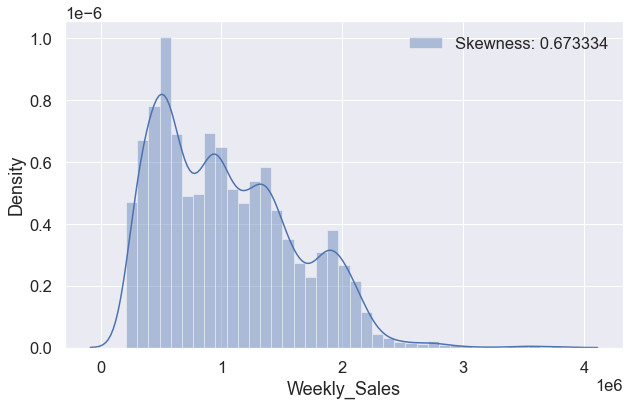

In [30]:
f, ax = plt.subplots(1, 1, figsize = (10,6)) 
g = sns.distplot(df_train["Weekly_Sales"], color = "b", label="Skewness: {:2f}".format(df_train["Weekly_Sales"].skew()), ax=ax) 
g = g.legend(loc = "best")

print("Skewness : %f" % df_train['Weekly_Sales'].skew())
print("Skewness : %f" % df_train['Weekly_Sales'].kurt())

# 다소 치우침이 있으니 조정해보도록 하자

## 2. EDA

1) not 수치형 데이터 확인하기
2) 수치형 데이터 확인하기

### 1) Date, IsHoliday 변수 탐색

In [ ]:
# Date 변수 탐색

In [43]:
df_train['Date'] = pd.to_datetime(df_train['Date'])

In [44]:
df_train.info()
# datetime 으로 변경 완.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            6255 non-null   int64         
 1   Store         6255 non-null   int64         
 2   Date          6255 non-null   datetime64[ns]
 3   Temperature   6255 non-null   float64       
 4   Fuel_Price    6255 non-null   float64       
 5   Promotion1    2102 non-null   float64       
 6   Promotion2    1592 non-null   float64       
 7   Promotion3    1885 non-null   float64       
 8   Promotion4    1819 non-null   float64       
 9   Promotion5    2115 non-null   float64       
 10  Unemployment  6255 non-null   float64       
 11  IsHoliday     6255 non-null   bool          
 12  Weekly_Sales  6255 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(9), int64(2)
memory usage: 592.6 KB


In [45]:
df_train['year'] = df_train['Date'].dt.year
df_train['month'] = df_train['Date'].dt.month

In [51]:
df_test['Date'] = pd.to_datetime(df_test['Date'])

df_test['year'] = df_test['Date'].dt.year
df_test['month'] = df_test['Date'].dt.month

In [52]:
df_test.info() # test 셋에 대해서도 변경해두기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            180 non-null    int64         
 1   Store         180 non-null    int64         
 2   Date          180 non-null    datetime64[ns]
 3   Temperature   180 non-null    float64       
 4   Fuel_Price    180 non-null    float64       
 5   Promotion1    178 non-null    float64       
 6   Promotion2    45 non-null     float64       
 7   Promotion3    161 non-null    float64       
 8   Promotion4    146 non-null    float64       
 9   Promotion5    180 non-null    float64       
 10  Unemployment  180 non-null    float64       
 11  IsHoliday     180 non-null    bool          
 12  year          180 non-null    int64         
 13  month         180 non-null    int64         
dtypes: bool(1), datetime64[ns](1), float64(8), int64(4)
memory usage: 18.6 KB


In [46]:
# 분리했으니 연도별 자료값 확인

df_train['year'].value_counts()

2011    2340
2010    2160
2012    1755
Name: year, dtype: int64

In [47]:
# 월별 자료 확인

df_train['month'].value_counts()

4     630
9     585
7     585
8     540
5     540
6     540
3     540
2     495
10    495
12    450
1     450
11    405
Name: month, dtype: int64

[Text(0, 0.5, 'Weekly_Sales'), Text(0.5, 1.0, 'Weekly Sales by dayofweek')]

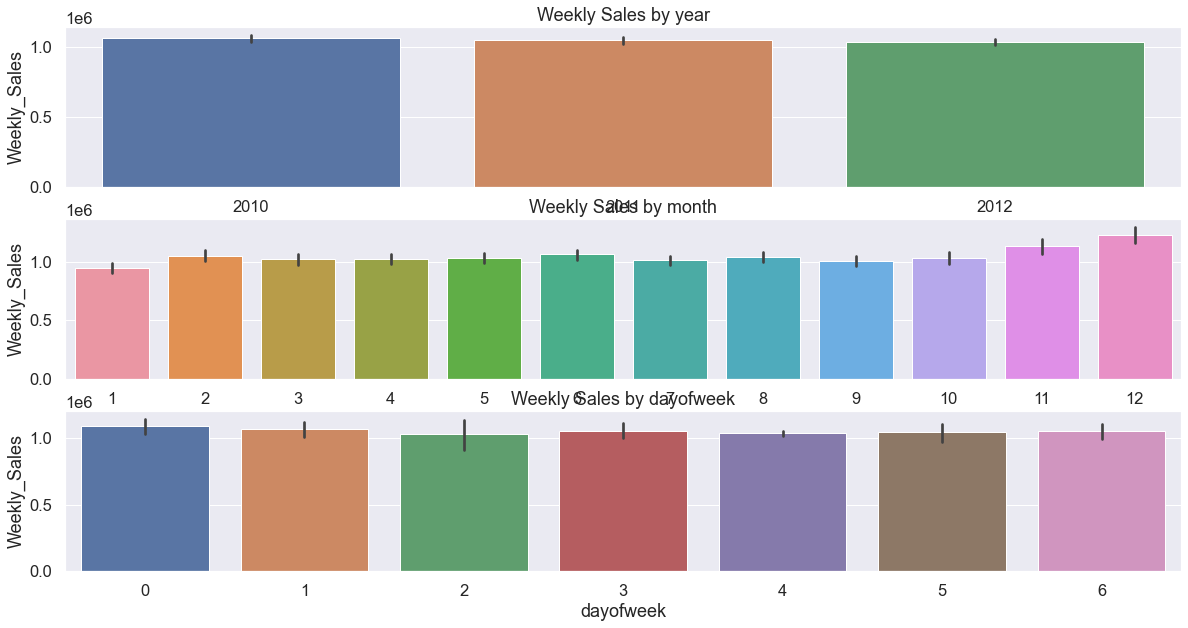

In [62]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1) 
figure.set_size_inches(20,10) 
sns.barplot(data=df_train, x = "year", y = "Weekly_Sales", ax = ax1) 
sns.barplot(data=df_train, x = "month", y = "Weekly_Sales", ax = ax2)
sns.barplot(data=df_train, x = "dayofweek", y = "Weekly_Sales", ax = ax3)

ax1.set(ylabel = "Weekly_Sales", title = "Weekly Sales by year") 
ax2.set(ylabel = "Weekly_Sales", title = "Weekly Sales by month") 
ax3.set(ylabel = "Weekly_Sales", title = "Weekly Sales by dayofweek") 

In [58]:
df_train['dayofweek'] = df_train['Date'].dt.dayofweek

In [60]:
df_train['dayofweek'].value_counts()

4    4230
0     450
1     405
6     405
3     405
5     270
2      90
Name: dayofweek, dtype: int64

<AxesSubplot:xlabel='dayofweek', ylabel='Weekly_Sales'>

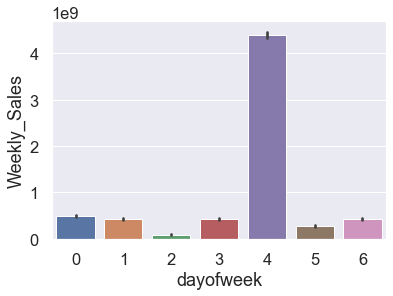

In [71]:
sns.barplot(data=df_train, x='dayofweek', y='Weekly_Sales',estimator=np.sum)

# 0: 월요일 ~ 6: 일요일
# 금요일의 구매량 합이 월등히 많음

<AxesSubplot:xlabel='month', ylabel='Weekly_Sales'>

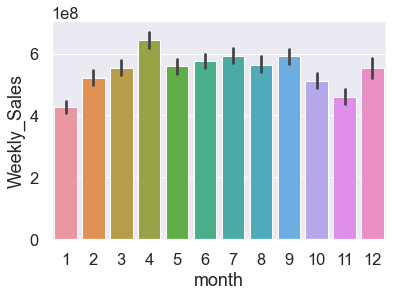

In [72]:
sns.barplot(data=df_train, x='month', y='Weekly_Sales',estimator=np.sum)

<AxesSubplot:xlabel='month', ylabel='Weekly_Sales'>

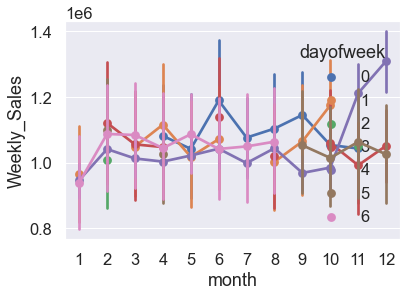

In [76]:
sns.pointplot(data = df_train, x = "month",hue = 'dayofweek', y = "Weekly_Sales") 

In [ ]:
# IsHoliday

In [48]:
df_train['IsHoliday'].value_counts() # 주말이 있던 주는 450번

False    5805
True      450
Name: IsHoliday, dtype: int64

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

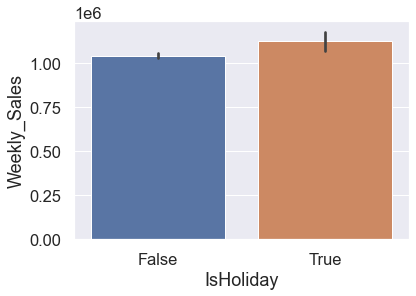

In [78]:
sns.barplot(data=df_train, x= 'IsHoliday', y ='Weekly_Sales')
# 공휴일에 당연 판매량이 높음

### 2) numeric feautures 탐색

In [79]:
df_train.columns

Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'year', 'month', 'dayofweek'],
      dtype='object')

In [80]:
corr_data = df_train[['Store','Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment', 'Weekly_Sales']]

<AxesSubplot:title={'center':'Correlation of Numeric Features with Weekly Sales'}>

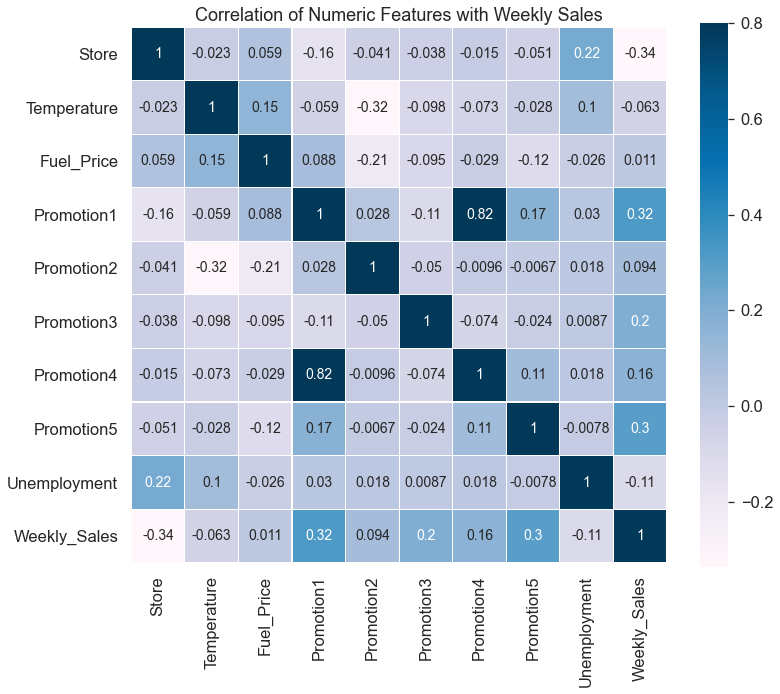

In [81]:
colormap = plt.cm.PuBu
f , ax = plt.subplots(figsize = (12,10)) 
plt.title('Correlation of Numeric Features with Weekly Sales', y=1,size=18) 
sns.heatmap(corr_data.corr(), vmax=.8, linewidths=0.1,square=True,annot=True,cmap=colormap, 
            linecolor="white",annot_kws = {'size':14})

promotion1과 promotion4는 굉장히 유사
도대체 promotion이 뭐야

In [82]:
df_train['Promotion1']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
6250    23641.30
6251    11024.45
6252    11407.95
6253     8452.20
6254     4556.61
Name: Promotion1, Length: 6255, dtype: float64

<AxesSubplot:xlabel='Store', ylabel='Fuel_Price'>

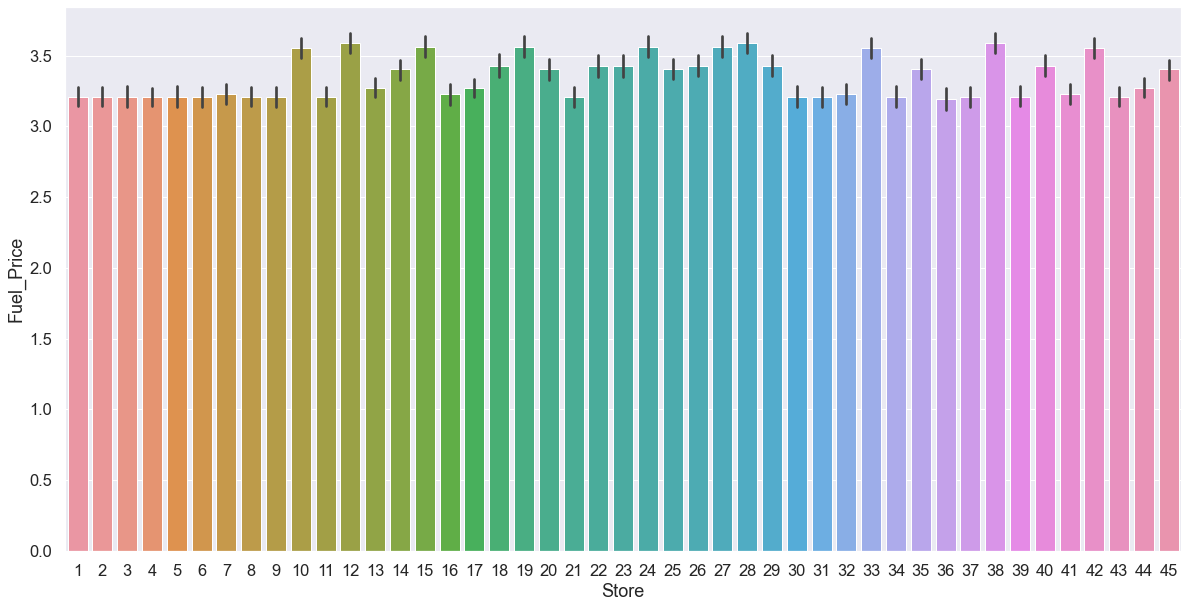

In [86]:
plt.figure(figsize=(20,10))
sns.barplot(data=df_train, x ='Store', y = 'Fuel_Price')

<AxesSubplot:xlabel='Store', ylabel='Unemployment'>

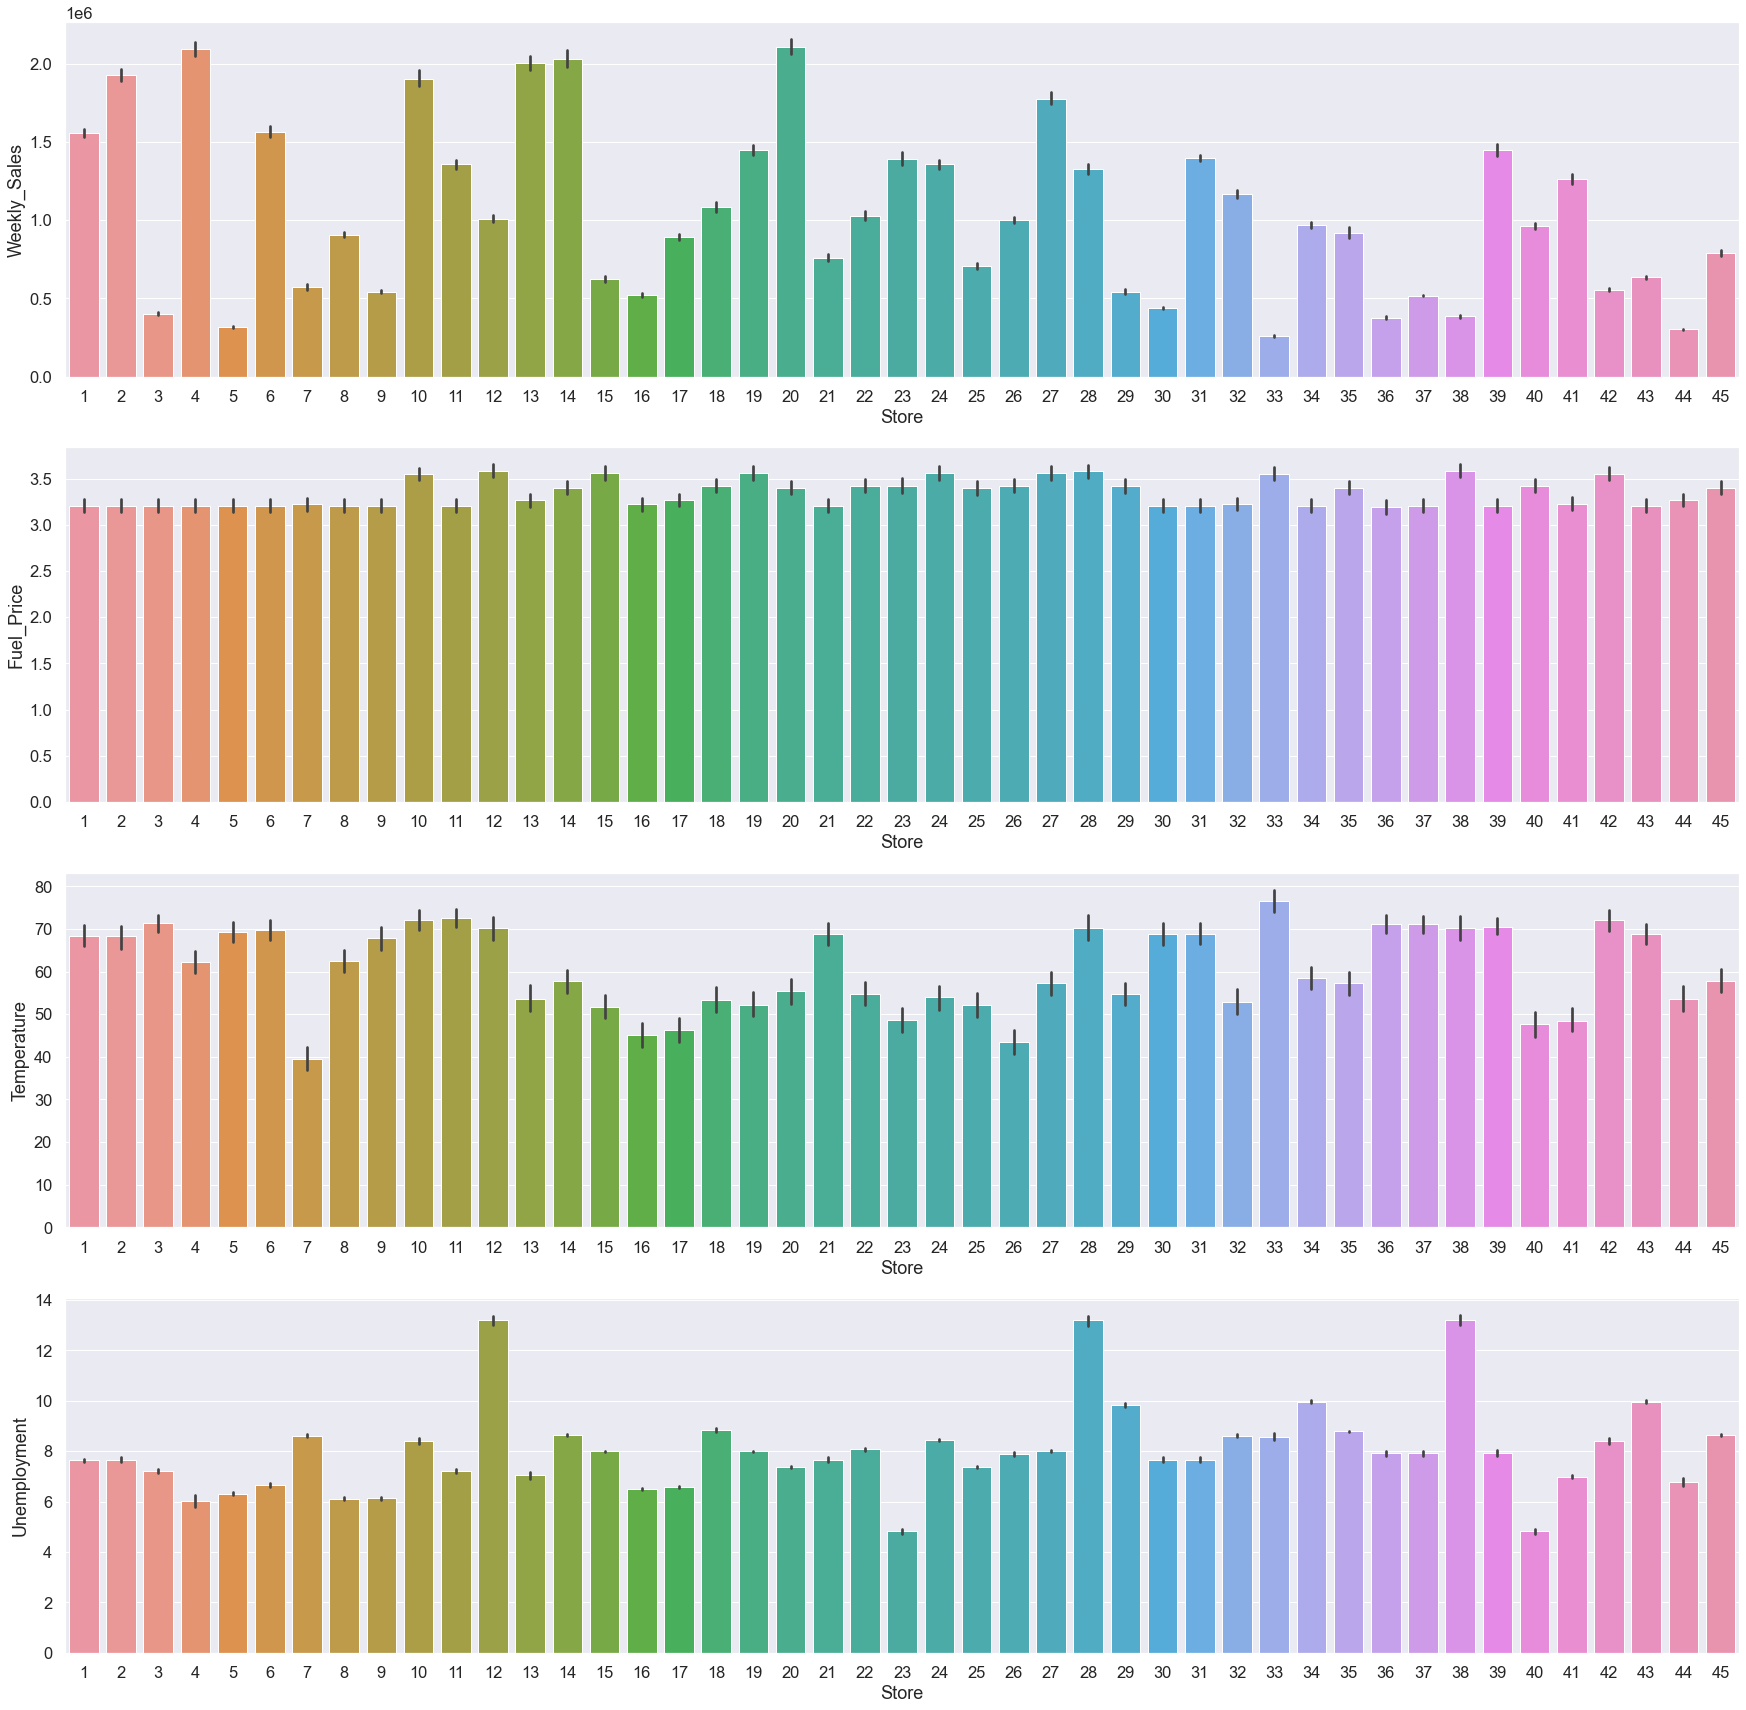

In [92]:
fig, ax = plt.subplots(nrows=4, figsize=(30,30))
sns.barplot(data=df_train, x ='Store', y = 'Weekly_Sales',ax = ax[0])
sns.barplot(data=df_train, x ='Store', y = 'Fuel_Price',ax = ax[1])
sns.barplot(data=df_train, x ='Store', y = 'Temperature',ax = ax[2])
sns.barplot(data=df_train, x ='Store', y = 'Unemployment',ax = ax[3])

## 3. Feature Engineering

## 4. Modeling & submission